# 鐵達尼號生存率預測

#### Markdown 方法
1. 定義、解釋程式a. 的用途
2. 說明程式a. 的結果，分析
3. 跑程式

In [25]:
# 數據分析的 Class
import pandas as pd
import numpy as np
import random as rnd

# 圖像化的 Class
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

# 機器學習的 Class
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC, LinearSVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.preprocessing import LabelEncoder
from sklearn.naive_bayes import GaussianNB
from sklearn.linear_model import Perceptron
from sklearn.linear_model import SGDClassifier
from sklearn.tree import DecisionTreeClassifier

# 用以顯示告訴的 Class
from IPython.display import display
from IPython.display import display_html
def display_side_by_side(*args):
    html_str=''
    for df in args:
        html_str+=df.to_html()
    display_html(html_str.replace('table','table style="display:inline"'),raw=True)
# 用以無視程式警告
import warnings
warnings.filterwarnings("ignore")

In [26]:
# 載入數據
df_train = pd.read_csv("train.csv")
df_test = pd.read_csv("test.csv")
df_data = df_train.append(df_test)

## 簡介

1912年4月10日，鐵達尼號展開首航，也是唯一一次的載客出航，最終目的地為紐約。部分乘客為當時世界上頂尖富豪，以及許多來自英國、愛爾蘭、斯堪地那維亞和整個歐洲其他地區的移民，他們尋求在美國展開新生活的機會。
4月15日在中途發生碰撞冰山後沉沒的嚴重災難。
2,224名船上人員中有1,514人罹難，成為近代史上最嚴重的和平時期船難。

此Project 以鐵達尼號船上人員的不同資料及其最後是否生存的情況，以機器學習的方法，預測一群船上人員是否存活。

#### 首先，我地睇一睇數據包內有甚麼資料給我們分析。資料分別為[年齡、船艙位置、上船港口、船票票價、名稱、兄弟姊妹、頭等\二等\三等、父母、姓名、船票號碼...]

In [27]:
print(df_data.columns.values)

['Age' 'Cabin' 'Embarked' 'Fare' 'Name' 'Parch' 'PassengerId' 'Pclass'
 'Sex' 'SibSp' 'Survived' 'Ticket']


#### 用 head() 開個table 黎睇下

In [28]:
df_data.head()

,Age,Cabin,Embarked,Fare,Name,Parch,PassengerId,Pclass,Sex,SibSp,Survived,Ticket
0,22.0,NaN,S,7.2500,"Braund, Mr. Owen Harris",0,1,3,male,1,0.0,A/5 21171
1,38.0,C85,C,71.2833,"Cumings, Mrs. John Bradley (Florence Briggs Th...",0,2,1,female,1,1.0,PC 17599
2,26.0,NaN,S,7.9250,"Heikkinen, Miss. Laina",0,3,3,female,0,1.0,STON/O2. 3101282
3,35.0,C123,S,53.1000,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",0,4,1,female,1,1.0,113803
4,35.0,NaN,S,8.0500,"Allen, Mr. William Henry",0,5,3,male,0,0.0,373450


#### 用info() 黎睇下 train數據包同 test數據包，可以睇到年齡、船艙位置、上船港口有缺少數據

In [29]:
df_train.info()
# print 用黎分隔 train 同 test 姐
print('_'*40)
df_test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 12 columns):
PassengerId    891 non-null int64
Survived       891 non-null int64
Pclass         891 non-null int64
Name           891 non-null object
Sex            891 non-null object
Age            714 non-null float64
SibSp          891 non-null int64
Parch          891 non-null int64
Ticket         891 non-null object
Fare           891 non-null float64
Cabin          204 non-null object
Embarked       889 non-null object
dtypes: float64(2), int64(5), object(5)
memory usage: 83.6+ KB
________________________________________
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 418 entries, 0 to 417
Data columns (total 11 columns):
PassengerId    418 non-null int64
Pclass         418 non-null int64
Name           418 non-null object
Sex            418 non-null object
Age            332 non-null float64
SibSp          418 non-null int64
Parch          418 non-null int64
Ticket         418 non-null

## 試下用圖表顯示各種特徵同生存率有沒有直接關係

#### 先睇性別與生存率既關係，我地可以發現女性既生活率高達 74%

,Sex,Survived
0,female,0.742
1,male,0.189


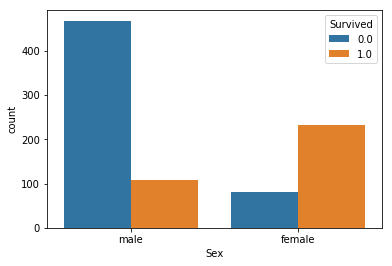

In [30]:
sns.countplot(df_data['Sex'], hue=df_data['Survived'])
display(df_data[["Sex", "Survived"]].groupby(['Sex'], as_index=False).mean().round(3))

#### 特徵會以數值表示，咁做程式會比較容易跑，所以我地改左數據變做
'female' : 1, 'male' : 0

In [31]:
# Convert Sex
df_data['Sex_Code'] = df_data['Sex'].map({'female' : 1, 'male' : 0}).astype('int')

#### 港口有缺少好少量數據，我直接填補為最多人上船既港口 'S'。之後我地再以圖表睇下港口同生存率的關係，發覺港口'C'既人有55%生存率。
因為生存/死亡係二元分佈，所以特徵與生存率的關係要超過50%以上才可以說這個特徵對生存率確實有重大既影響。

,Embarked,Survived
0,C,0.554
1,Q,0.390
2,S,0.339


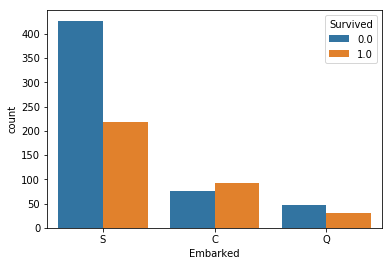

In [32]:
df_data['Embarked'] = df_data['Embarked'].fillna('S')
sns.countplot(df_data['Embarked'], hue=df_data['Survived'])
display(df_data[["Embarked", "Survived"]].groupby(['Embarked'], as_index=False).mean().round(3))

#### 我地再以圖表睇下頭等/二等/三等同生存率的關係，發覺頭等既生存率有63%，可以想想用唔用

,Pclass,Survived
0,1,0.630
1,2,0.473
2,3,0.242


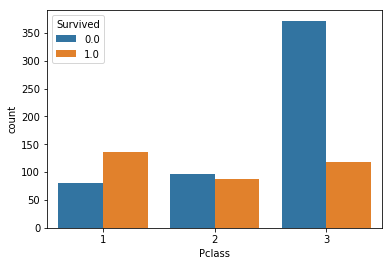

In [33]:
sns.countplot(df_data['Pclass'], hue=df_data['Survived'])
display(df_data[["Pclass", "Survived"]].groupby(['Pclass'], as_index=False).mean().round(3))

In [34]:
# Non-easy to Plot Age, Fare, Parch, SibSp

#### 關於票價，票價具有連續性，所以我地將票價分割會幾份。
首先，我地用數據既Median 補回數據包入面缺少既部份。
之後我地分割票價，我地分割年齡會 4份, 5份, 6份。
再以圖表表示，發現分就 6份既時候，其中一組既生存率超過50%

Pclass,1,2,3
FareBin_Code_4,,,
0,8,6,323
1,0,128,193
2,77,104,147
3,238,39,46
Pclass,1,2,3
FareBin_Code_5,,,
0,8,6,261
1,0,36,218
2,0,124,132


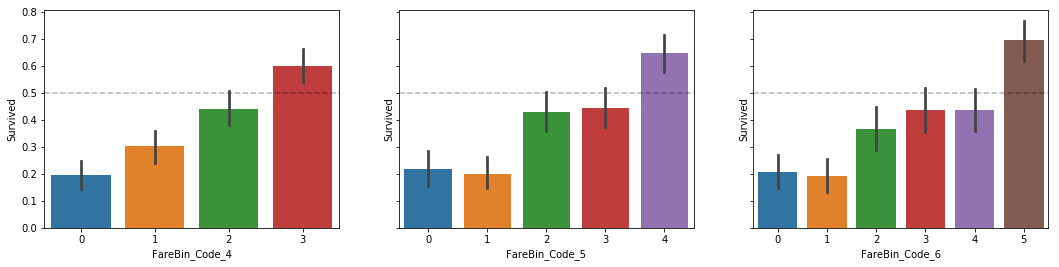

In [35]:
# Filling missing values
df_data['Fare'] = df_data['Fare'].fillna(df_data['Fare'].median())

# Making Bins
df_data['FareBin_4'] = pd.qcut(df_data['Fare'], 4)
df_data['FareBin_5'] = pd.qcut(df_data['Fare'], 5)
df_data['FareBin_6'] = pd.qcut(df_data['Fare'], 6)

label = LabelEncoder()
df_data['FareBin_Code_4'] = label.fit_transform(df_data['FareBin_4'])
df_data['FareBin_Code_5'] = label.fit_transform(df_data['FareBin_5'])
df_data['FareBin_Code_6'] = label.fit_transform(df_data['FareBin_6'])

# cross tab
df_4 = pd.crosstab(df_data['FareBin_Code_4'],df_data['Pclass'])
df_5 = pd.crosstab(df_data['FareBin_Code_5'],df_data['Pclass'])
df_6 = pd.crosstab(df_data['FareBin_Code_6'],df_data['Pclass'])

display_side_by_side(df_4,df_5,df_6)

# plots
fig, [ax1, ax2, ax3] = plt.subplots(1, 3,sharey=True)
fig.set_figwidth(18)
for axi in [ax1, ax2, ax3]:
    axi.axhline(0.5,linestyle='dashed', c='black',alpha = .3)
g1 = sns.factorplot(x='FareBin_Code_4', y="Survived", data=df_data,kind='bar',ax=ax1)
g2 = sns.factorplot(x='FareBin_Code_5', y="Survived", data=df_data,kind='bar',ax=ax2)
g3 = sns.factorplot(x='FareBin_Code_6', y="Survived", data=df_data,kind='bar',ax=ax3)
# close FacetGrid object
plt.close(g1.fig)
plt.close(g2.fig)
plt.close(g3.fig)

#### 關於年齡，年齡具有連續性，所以我地將年齡分割會幾份。
首先，我地用數據既Median 補回數據包入面缺少既部份。
之後我地分割年齡，我地分割年齡會 4份, 5份, 20份。
再以圖表表示，發現分就 20份既時候，其中一組既生存率超過50%

Pclass,1,2,3
AgeBin_Code_4,,,
0,38,69,226
1,74,77,315
2,45,59,84
3,166,72,84
Pclass,1,2,3
AgeBin_Code_5,,,
0,31,63,196
1,81,83,345
2,77,75,113


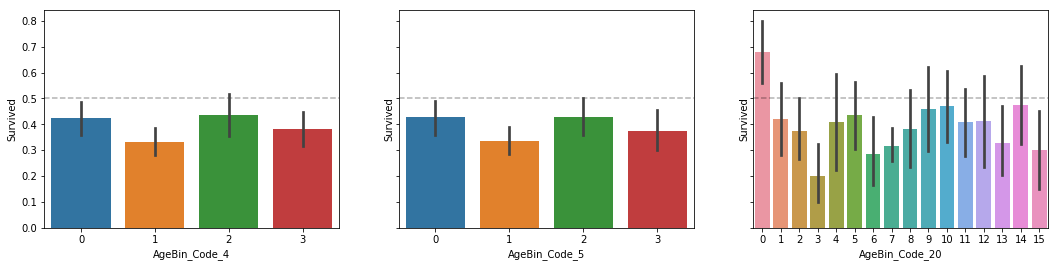

In [36]:
# Filling missing values
df_data['Age'] = df_data['Age'].fillna(df_data['Age'].median())

# Making Bins
df_data['AgeBin_4'] = pd.qcut(df_data['Age'], 4,duplicates ='drop')
df_data['AgeBin_5'] = pd.qcut(df_data['Age'], 5,duplicates ='drop')
df_data['AgeBin_20'] = pd.qcut(df_data['Age'], 20,duplicates ='drop')

label = LabelEncoder()
df_data['AgeBin_Code_4'] = label.fit_transform(df_data['AgeBin_4'])
df_data['AgeBin_Code_5'] = label.fit_transform(df_data['AgeBin_5'])
df_data['AgeBin_Code_20'] = label.fit_transform(df_data['AgeBin_20'])

# cross tab
df_4 = pd.crosstab(df_data['AgeBin_Code_4'],df_data['Pclass'])
df_5 = pd.crosstab(df_data['AgeBin_Code_5'],df_data['Pclass'])
df_6 = pd.crosstab(df_data['AgeBin_Code_20'],df_data['Pclass'])

display_side_by_side(df_4,df_5,df_6)

# plots
fig, [ax1, ax2, ax3] = plt.subplots(1, 3,sharey=True)
fig.set_figwidth(18)
for axi in [ax1, ax2, ax3]:
    axi.axhline(0.5,linestyle='dashed', c='black',alpha = .3)
g1 = sns.factorplot(x='AgeBin_Code_4', y="Survived", data=df_data,kind='bar',ax=ax1)
g2 = sns.factorplot(x='AgeBin_Code_5', y="Survived", data=df_data,kind='bar',ax=ax2)
g3 = sns.factorplot(x='AgeBin_Code_20', y="Survived", data=df_data,kind='bar',ax=ax3)
# close FacetGrid object
plt.close(g1.fig)
plt.close(g2.fig)
plt.close(g3.fig)

#### 船艙，船艙既名稱有多又有唔一樣，又有缺少數據，我地先將數據補回來，我地以'X'(無數據)，之後我地將船艙名稱字頭表示船艙。再以圖表顯示，發現某幾個船艙的生存率比較高。

In [37]:
df_data['Cabin'] = df_data['Cabin'].fillna('X')
df_data['Cabin'] = df_data['Cabin'].apply(lambda x:str(x)[0])

,Cabin,Survived
0,A,0.467
1,B,0.745
2,C,0.593
3,D,0.758
4,E,0.750
5,F,0.615
6,G,0.500
7,T,0.000
8,X,0.300


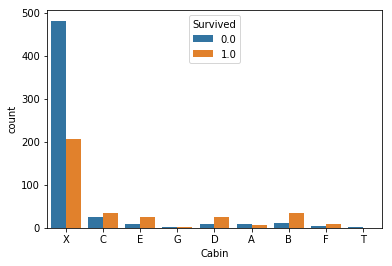

In [38]:
sns.countplot(df_data['Cabin'], hue=df_data['Survived'])
display(df_data[["Cabin", "Survived"]].groupby(['Cabin'], as_index=False).mean().round(3))

#### 名稱有多又有唔一樣，不過我地可以將名稱稱呼分四類，"Mr":0, "Rare" : 1, "Master" : 2,"Miss" : 3, "Mrs" : 4 
再用圖表顯示下，叫Miss 同 Mrs 既 (女性) 生存率都係比較好。

In [39]:
# extracted title using name
df_data['Title'] = df_data.Name.str.extract(' ([A-Za-z]+)\.', expand=False)
df_data['Title'] = df_data['Title'].replace(['Capt', 'Col', 'Countess', 'Don',
                                               'Dr', 'Dona', 'Jonkheer', 
                                                'Major','Rev','Sir'],'Rare') 
df_data['Title'] = df_data['Title'].replace(['Mlle', 'Ms','Mme'],'Miss')
df_data['Title'] = df_data['Title'].replace(['Lady'],'Mrs')
df_data['Title'] = df_data['Title'].map({"Mr":0, "Rare" : 1, "Master" : 2,"Miss" : 3, "Mrs" : 4 })

,Title,Survived
0,0,0.157
1,1,0.318
2,2,0.575
3,3,0.704
4,4,0.794


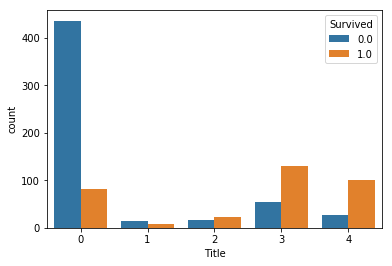

In [40]:
sns.countplot(df_data['Title'], hue=df_data['Survived'])
display(df_data[["Title", "Survived"]].groupby(['Title'], as_index=False).mean().round(3))

連結(Connected_Survival)
這個特徵相當有意思，主要是發現了乘客持有相同的船票意味著他們可能是家人或是朋友，而在訓練集上這些互相有連結的人常常是一起活下來或是一起喪命，我們從票根的特徵Ticket開始看起在891個票根資訊中，獨立的有681項，這表示一定有乘客是持有相同的票根，這意味著他們可能一起分享某一區的座位......


In [41]:
# Ticket
df_data['Family_size'] = df_data['SibSp'] + df_data['Parch'] + 1

,Parch,Survived
0,0,0.344
1,1,0.551
2,2,0.500
3,3,0.600
4,4,0.000
5,5,0.200
6,6,0.000
7,9,NaN


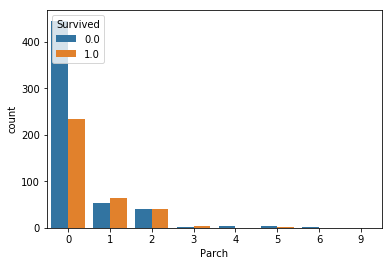

In [42]:
sns.countplot(df_data['Parch'], hue=df_data['Survived'])
display(df_data[["Parch", "Survived"]].groupby(['Parch'], as_index=False).mean().round(3))

,SibSp,Survived
0,0,0.345
1,1,0.536
2,2,0.464
3,3,0.250
4,4,0.167
5,5,0.000
6,8,0.000


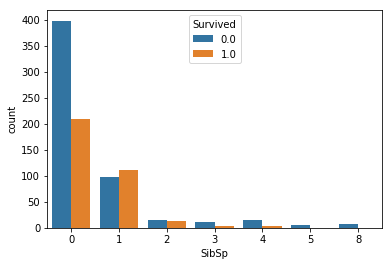

In [43]:
sns.countplot(df_data['SibSp'], hue=df_data['Survived'])
display(df_data[["SibSp", "Survived"]].groupby(['SibSp'], as_index=False).mean().round(3))

In [44]:
deplicate_ticket = []
for tk in df_data.Ticket.unique():
    tem = df_data.loc[df_data.Ticket == tk, 'Fare']
    #print(tem.count())
    if tem.count() > 1:
        #print(df_data.loc[df_data.Ticket == tk,['Name','Ticket','Fare']])
        deplicate_ticket.append(df_data.loc[df_data.Ticket == tk,['Name','Ticket','Fare','Cabin','Family_size','Survived']])
deplicate_ticket = pd.concat(deplicate_ticket)
deplicate_ticket.head(14)

,Name,Ticket,Fare,Cabin,Family_size,Survived
1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",PC 17599,71.2833,C,2,1.0
234,"Cumings, Mr. John Bradley",PC 17599,71.2833,C,2,NaN
3,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",113803,53.1000,C,2,1.0
137,"Futrelle, Mr. Jacques Heath",113803,53.1000,C,2,0.0
6,"McCarthy, Mr. Timothy J",17463,51.8625,E,1,0.0
146,"Hilliard, Mr. Herbert Henry",17463,51.8625,E,1,NaN
7,"Palsson, Master. Gosta Leonard",349909,21.0750,X,5,0.0
24,"Palsson, Miss. Torborg Danira",349909,21.0750,X,5,0.0
374,"Palsson, Miss. Stina Viola",349909,21.0750,X,5,0.0
567,"Palsson, Mrs. Nils (Alma Cornelia Berglund)",349909,21.0750,X,5,0.0


In [45]:
# the same ticket family or friends
df_data['Connected_Survival'] = 0.5 # default 
for _, df_grp in df_data.groupby('Ticket'):
    if (len(df_grp) > 1):
        for ind, row in df_grp.iterrows():
            smax = df_grp.drop(ind)['Survived'].max()
            smin = df_grp.drop(ind)['Survived'].min()
            passID = row['PassengerId']
            if (smax == 1.0):
                df_data.loc[df_data['PassengerId'] == passID, 'Connected_Survival'] = 1
            elif (smin==0.0):
                df_data.loc[df_data['PassengerId'] == passID, 'Connected_Survival'] = 0
#print
print('people keep the same ticket: %.0f '%len(deplicate_ticket))
print("people have connected information : %.0f" 
      %(df_data[df_data['Connected_Survival']!=0.5].shape[0]))
df_data.groupby('Connected_Survival')[['Survived']].mean().round(3)

people keep the same ticket: 596 
people have connected information : 496


,Survived
Connected_Survival,
0.0,0.225
0.5,0.298
1.0,0.728


### 我地用 One-hot encoding 既方法對付'Connected_Survival'、'船艙'、'港口'

In [46]:
df_data = pd.concat([df_data,pd.get_dummies(df_data['Connected_Survival'],prefix='Connected_Survival')],axis=1)
df_data = pd.concat([df_data,pd.get_dummies(df_data['Cabin'],prefix='Cabin')],axis=1)
df_data = pd.concat([df_data,pd.get_dummies(df_data['Embarked'],prefix='Embarked')],axis=1)

In [47]:
df_data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1309 entries, 0 to 417
Data columns (total 43 columns):
Age                       1309 non-null float64
Cabin                     1309 non-null object
Embarked                  1309 non-null object
Fare                      1309 non-null float64
Name                      1309 non-null object
Parch                     1309 non-null int64
PassengerId               1309 non-null int64
Pclass                    1309 non-null int64
Sex                       1309 non-null object
SibSp                     1309 non-null int64
Survived                  891 non-null float64
Ticket                    1309 non-null object
Sex_Code                  1309 non-null int32
FareBin_4                 1309 non-null category
FareBin_5                 1309 non-null category
FareBin_6                 1309 non-null category
FareBin_Code_4            1309 non-null int32
FareBin_Code_5            1309 non-null int32
FareBin_Code_6            1309 non-null int32
A

In [48]:
# split training set the testing set
# 分開返 training set 同 test set
df_train = df_data[:len(df_train)]
df_test = df_data[len(df_train):]

In [49]:
# Inputs set and labels
X = df_train.drop(labels=['Survived','PassengerId'],axis=1)
Y = df_train['Survived']

#### 我用 RandomForestClassifier 去做預測測驗，我最後選擇既特徵係 Title , Pclass, Fare_code6, Connected_Survival 試試先
叫 Base_Model
出黎效果有 0.84063 分

In [51]:
# Show Baseline
Base = ['Sex_Code','Pclass','FareBin_Code_6','Title','Connected_Survival_0.0','Connected_Survival_0.5','Connected_Survival_1.0']
Base_Model = RandomForestClassifier(random_state=2,n_estimators=250,min_samples_split=30,oob_score=True)
Base_Model.fit(X[Base], Y)
print('Base oob score :%.5f' %(Base_Model.oob_score_))

Base oob score :0.84063


放上網 ，上網俾我地既結果 係有0.79904 所以我決定再執執

In [52]:
# submission if you want
# submits
X_Submit = df_test.drop(labels=['PassengerId'],axis=1)

Base_pred = Base_Model.predict(X_Submit[Base])

submit = pd.DataFrame({"PassengerId": df_test['PassengerId'],
                      "Survived":Base_pred.astype(int)})
submit.to_csv("Base.csv",index=False)

#### 第二次，我用 RandomForestClassifier 去做預測測驗，我最後選擇既特徵係 Title , Pclass, Fare_code5, Connected_Survival 試試先
叫 New_Model
出黎效果有 0.84287 分

In [53]:
# Show Newline
New = ['Title','Pclass','FareBin_Code_5','Connected_Survival']
New_Model = RandomForestClassifier(random_state=2,n_estimators=250,min_samples_split=30,oob_score=True)
New_Model.fit(X[New], Y)
print('New oob score :%.5f' %(New_Model.oob_score_))

New oob score :0.84287


放上網 ，上網俾我地既結果 係有0.81339 所以我決定交功課啦

In [54]:
# submission if you want
# submits
X_Submit = df_test.drop(labels=['PassengerId'],axis=1)

New_pred = New_Model.predict(X_Submit[New])

submit = pd.DataFrame({"PassengerId": df_test['PassengerId'],
                      "Survived":New_pred.astype(int)})
submit.to_csv("New.csv",index=False)